### Loading the dataset containing the export data alongside with the nodal attribute available on each country

In [4]:
# edges = read.csv('../datasets/wits/edgelist_2011.csv')
# nodes = read.csv('../datasets/wits/nodelist_2011.csv')
nodes = read.csv('../datasets/wits/nl_no_missing.csv')
edges = read.csv('../datasets/wits/el_no_missing.csv')

In [5]:
n = dim(nodes)[1]
country_names = nodes$country_iso3
nodes = transform(nodes, landlocked=as.logical(landlocked))

### Importing the library required for doing permutation tests

In [6]:
library(coin)
library(sna)
library(ergm)

In [7]:
head(nodes, 3)

,country_iso3,gdp_us_dollar,inflation_rate,gdp_growth,colonizer,area,landlocked,continent,langoff_1,population,gdp_per_capita,life_expectancy,gni_atlas,agriculture_forestry_fishing_of_gdp,industry_of_gdp,merchandise_of_gdp,net_barter_of_trade,foreign_direct_investment_inflows,happiness
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<lgl>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AFG,17804292964,11.804186,0.4263548,USA,652225,TRUE,Asia,Persian,30117411,591.1628,61.553,16077121256,23.743664,22.74025,38.70415,144.7519,52173421,0.721
2,AGO,111789686464,13.482468,3.4719763,PRT,1246700,FALSE,Africa,Portuguese,24220660,4615.4682,56.330,82606027251,5.845681,56.02651,78.30597,244.3292,-3023770966,0.708
3,ALB,12890765324,3.429123,2.5453218,NONE,28748,FALSE,Europe,Albanian,2905195,4437.1429,76.914,12803715190,18.226765,24.48441,56.86241,94.3372,1048706682,0.568


In [8]:
head(edges, 3)

,source,target,weight
,<chr>,<chr>,<dbl>
1,NPL,LBR,97.061
2,NPL,AZE,46.502
3,NPL,JOR,25.551


In [9]:
net = network(edges, directed = TRUE, matrix.type = 'edgelist')
set.vertex.attribute(x = net, attrname = colnames(nodes), value = nodes)
net

 Network attributes:
  vertices = 141 
  directed = TRUE 
  hyper = FALSE 
  loops = FALSE 
  multiple = FALSE 
  bipartite = FALSE 
  total edges= 14367 
    missing edges= 0 
    non-missing edges= 14367 

 Vertex attribute names: 
    agriculture_forestry_fishing_of_gdp area colonizer continent country_iso3 foreign_direct_investment_inflows gdp_growth gdp_per_capita gdp_us_dollar gni_atlas happiness industry_of_gdp inflation_rate landlocked langoff_1 life_expectancy merchandise_of_gdp net_barter_of_trade population vertex.names 

 Edge attribute names not shown 

### Generating the adjacency matrix of the export network and the total Export/Import of all countries

In [10]:
countries_export_import = data.frame(
    country = c(nodes$country_iso3), 
    exports = matrix(0, nrow =n , ncol = 1),
    imports = matrix(0, nrow =n , ncol = 1)
)

In [11]:
for (i in 1:length(nodes$country_iso3)) {
    countries_export_import[i, 2:3] = c(
        sum(edges$weight[edges$source == countries_export_import$country[i]]), 
        sum(edges$weight[edges$target == countries_export_import$country[i]])
    )
}

In [12]:
head(countries_export_import, 3)

,country,exports,imports
,<chr>,<dbl>,<dbl>
1,AFG,249732.5,11475161
2,AGO,60737102.0,16916900
3,ALB,1741441.8,4307616


In [13]:
nodes$exports = countries_export_import$exports
nodes$imports = countries_export_import$imports

In [14]:
head(nodes, 3)

,country_iso3,gdp_us_dollar,inflation_rate,gdp_growth,colonizer,area,landlocked,continent,langoff_1,population,⋯,life_expectancy,gni_atlas,agriculture_forestry_fishing_of_gdp,industry_of_gdp,merchandise_of_gdp,net_barter_of_trade,foreign_direct_investment_inflows,happiness,exports,imports
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<lgl>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AFG,17804292964,11.804186,0.4263548,USA,652225,TRUE,Asia,Persian,30117411,⋯,61.553,16077121256,23.743664,22.74025,38.70415,144.7519,52173421,0.721,249732.5,11475161
2,AGO,111789686464,13.482468,3.4719763,PRT,1246700,FALSE,Africa,Portuguese,24220660,⋯,56.330,82606027251,5.845681,56.02651,78.30597,244.3292,-3023770966,0.708,60737102.0,16916900
3,ALB,12890765324,3.429123,2.5453218,NONE,28748,FALSE,Europe,Albanian,2905195,⋯,76.914,12803715190,18.226765,24.48441,56.86241,94.3372,1048706682,0.568,1741441.8,4307616


In [15]:
adj_matrix = matrix(0, nrow = n, ncol = n)
for (i in 1:n) {
    for (j in i:n) {
        if (sum(edges$source == country_names[i] & edges$target == country_names[j]) > 0) {
            adj_matrix[i, j] = edges$weight[edges$source == country_names[i] & edges$target == country_names[j]]
        }
    }
}
diag(adj_matrix) = 0

### Loading the dataset of distances between countries

In [16]:
distance_data = read.csv('../datasets/wits/dist.csv')
head(distance_data, 3)

,source,target,dist
,<chr>,<chr>,<dbl>
1,AFG,AFG,303.7614
2,AFG,AGO,7607.8000
3,AFG,ALB,4342.1170


In [17]:
dist_matrix = matrix(0, nrow = n, ncol = n)
for (i in 1:n) {
    for (j in i:n) {
        if (sum(distance_data$source == country_names[i] & distance_data$target == country_names[j]) > 0) {
            dist_matrix[i, j] = distance_data$dist[distance_data$source == country_names[i] & distance_data$target == country_names[j]]
        }
    }
}
dist_matrix = dist_matrix + t(dist_matrix)
diag(dist_matrix) = 0

In [18]:
# Execute QAP test given y_matrix as the dependent network and the x_matrix as the indepdent network. 
# This kind of permutation test finds the permutations of the indepdent network which are kept the dependencies within the independent network
execute_qaptest = function(y_matrix, x_matrix, reps=1000) {
    wits.qap = qaptest(dat = list(y_matrix, x_matrix), gcor, g1=1, g2=2, reps = 1000)
    print(wits.qap)
    print(wits.qap$testval)
    par(bg = 'white')
    plot(wits.qap, xlim=c(min(min(wits.qap$dist), wits.qap$testval), max(max(wits.qap$dist), wits.qap$testval)))
    abline(v=wits.qap$testval, col='red')
}


QAP Test Results

Estimated p-values:
	p(f(perm) >= f(d)): 0.995 
	p(f(perm) <= f(d)): 0.005 

[1] -0.03837103


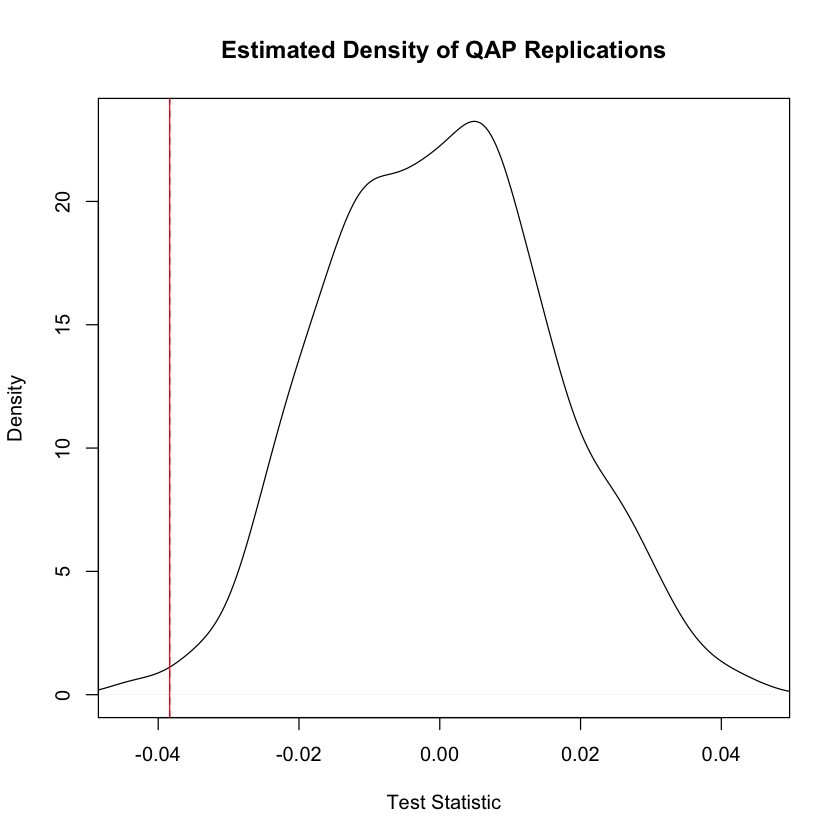

In [19]:
execute_qaptest(adj_matrix, dist_matrix)

### Checking the effect of colonization specifically in case of Great Britain

In [20]:
observed_statistic_exports_col = sum(nodes$exports[nodes$colonizer == 'GBR'])
observed_statistic_imports_col = sum(nodes$imports[nodes$colonizer == 'GBR'])

In [21]:
N = 100000

permutation_matrix_col = matrix(0, nrow = n, ncol = N)
for (i in 1:N) {
    permutation_matrix_col[, i] = sample(nodes$colonizer, size = n, replace = F)
}

In [22]:
permutated_statistic_exports_col = matrix(0, nrow=N, ncol=1)
permutated_statistic_imports_col = matrix(0, nrow=N, ncol=1)
for (i in 1:N) {
    permutated_statistic_exports_col[i,] = sum(nodes$exports[permutation_matrix_col[,i] == 'GBR'])
    permutated_statistic_imports_col[i,] = sum(nodes$imports[permutation_matrix_col[,i] == 'GBR'])
}

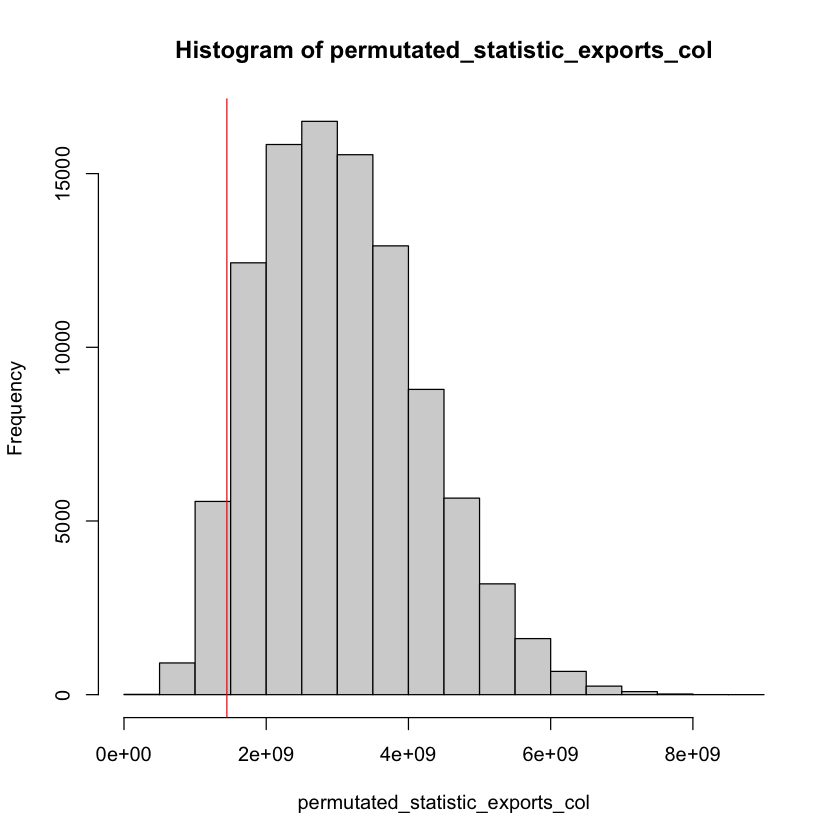

In [23]:
par(bg = 'white')
hist(permutated_statistic_exports_col)
abline(v=observed_statistic_exports_col, col='red')

In [24]:
mean(permutated_statistic_exports_col < observed_statistic_exports_col)

[1] 0.05516

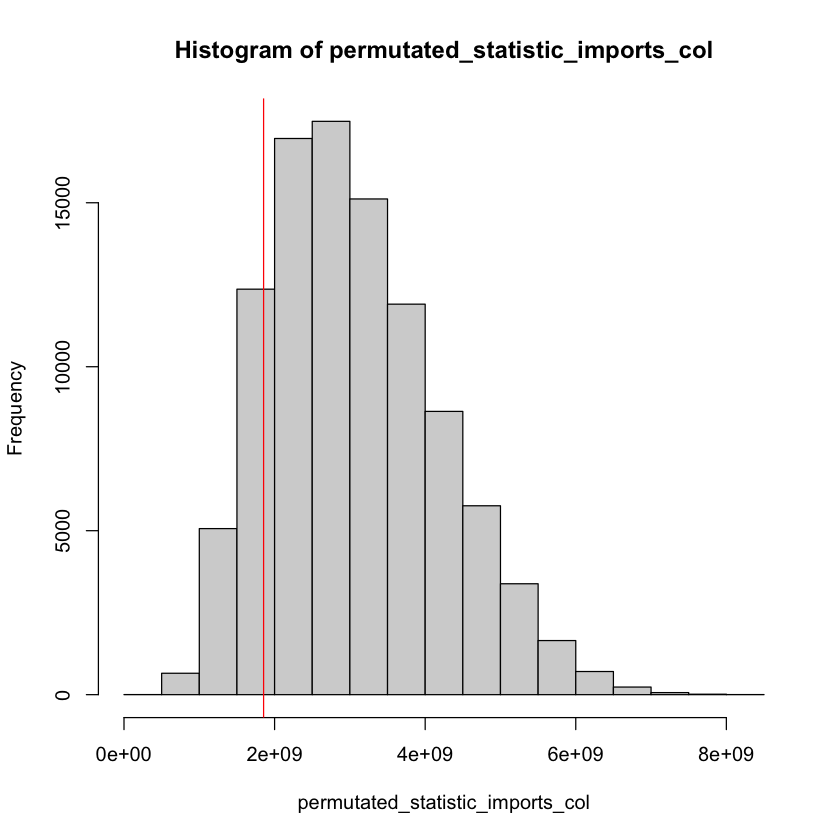

In [25]:
par(bg = 'white')
hist(permutated_statistic_imports_col)
abline(v=observed_statistic_imports_col, col='red')

In [26]:
mean(permutated_statistic_imports_col < observed_statistic_imports_col)

[1] 0.13806

### Examining the effect of homophily on the network of trades

In [27]:
count_homophily = function(edges, nodes, attrs, ...) {
    count = 0
    for (i in 1:dim(edges)[1]) {
        if (attrs[nodes$country_iso3 == edges$source[i]] == attrs[nodes$country_iso3 == edges$target[i]]) {
            count = count + 1
        }
    }
    return(count)
}

In [60]:
execute_permutation_test = function(edges, nodes, func, attrs, attr, ...) {
    params = list(...)
    observed_statistic = func(edges, nodes, attrs, params)
    
    N = 1000
    n = dim(nodes)[1]
    
#     generating new samples by permutating the attributes
    permutated_samples = matrix(0, nrow = n, ncol = N)
    for (i in 1:N) {
        permutated_samples[, i] = sample(x = attrs, size = n, replace = F)
    }
    
#    computing the specified statistic for all the permutated networks
    permutated_statistics = matrix(0, nrow = N, ncol = 1)
    for (j in 1:N) {
        permutated_statistics[j] = func(edges, nodes, permutated_samples[, j], params)
    }
    
    p_value = mean(permutated_statistics < observed_statistic)
    if (p_value > .5) {
        p_value = 1 - p_value
    }
    
    print(paste(attr, ',', p_value))
    pdf(paste('../results/', attr, '.pdf'))
    par(bg = 'white')
    hist(
        permutated_statistics, 
        xlim=c(min(min(permutated_statistics), observed_statistic), max(max(permutated_statistics), observed_statistic)), 
        main = paste('Comparison of the observed statistic and \npermutated ones with respect to \n', attr, 'with p-value: ', p_value)
    )
    abline(v=observed_statistic, col='red')
    
    dev.off()
}

In [61]:
categories = !unlist(lapply(nodes, FUN = is.numeric))
categories[attr(categories, 'names') == 'country_iso3'] = FALSE
categories = colnames(nodes[, categories])

In [62]:
for (col in categories) {
    execute_permutation_test(edges, nodes, count_homophily, nodes[, col], paste('homophily ', as.character(col)))
}

[1] "homophily  colonizer , 0"
[1] "homophily  landlocked , 0"
[1] "homophily  continent , 0"
[1] "homophily  langoff_1 , 0.016"


### Examining the effect of closeness

In [63]:
compute_nodecov = function(edges, nodes, attrs, ...) {
#     log transformation parameter
    params = list(...)
    sum = 0
    for (i in 1:dim(edges)[1]) {
        if (as.logical(params[[1]])) {
            sum = sum + log(attrs[nodes$country_iso3 == edges$source[i]] + attrs[nodes$country_iso3 == edges$target[i]])
        } else {
            sum = sum + attrs[nodes$country_iso3 == edges$source[i]] + attrs[nodes$country_iso3 == edges$target[i]]
        }
    }
    return(sum)
}

In [64]:
compute_absdiff = function(edges, nodes, attrs, ...) {
#     log transformation parameter
    params = list(...)
    diff_sum = 0
    for (i in 1:dim(edges)[1]) {
        if (as.logical(params[[1]])) {
            diff_sum = diff_sum + log(1 + abs(attrs[nodes$country_iso3 == edges$source[i]] - attrs[nodes$country_iso3 == edges$target[i]]))
        } else {
            diff_sum = diff_sum + abs(attrs[nodes$country_iso3 == edges$source[i]] - attrs[nodes$country_iso3 == edges$target[i]])
        }
    }
    return(diff_sum)
}

In [65]:
nums <- unlist(lapply(nodes, is.numeric))
nums = colnames(nodes[, nums])

In [67]:
for (col in nums) {
    execute_permutation_test(edges, nodes, compute_nodecov, nodes[, col], paste('nodecov ', as.character(col)), FALSE)
    execute_permutation_test(edges, nodes, compute_absdiff, nodes[, col], paste('absdiff ', as.character(col)), FALSE)
}

[1] "nodecov  gdp_us_dollar , 0"
[1] "absdiff  gdp_us_dollar , 0"
[1] "nodecov  inflation_rate , 0.016"
[1] "absdiff  inflation_rate , 0.142"
[1] "nodecov  gdp_growth , 0.453"
[1] "absdiff  gdp_growth , 0.02"
[1] "nodecov  area , 0.001"
[1] "absdiff  area , 0.001"
[1] "nodecov  population , 0"
[1] "absdiff  population , 0"
[1] "nodecov  gdp_per_capita , 0"
[1] "absdiff  gdp_per_capita , 0"
[1] "nodecov  life_expectancy , 0"
[1] "absdiff  life_expectancy , 0.001"
[1] "nodecov  gni_atlas , 0"
[1] "absdiff  gni_atlas , 0"
[1] "nodecov  agriculture_forestry_fishing_of_gdp , 0"
[1] "absdiff  agriculture_forestry_fishing_of_gdp , 0"
[1] "nodecov  industry_of_gdp , 0.104"
[1] "absdiff  industry_of_gdp , 0"
[1] "nodecov  merchandise_of_gdp , 0.247"
[1] "absdiff  merchandise_of_gdp , 0.0639999999999999"
[1] "nodecov  net_barter_of_trade , 0"
[1] "absdiff  net_barter_of_trade , 0.001"
[1] "nodecov  foreign_direct_investment_inflows , 0"
[1] "absdiff  foreign_direct_investment_inflows , 0"
[1] "n

### Transform numerical data to categorical and do homophily test

In [68]:
for (col in nums) {
    values = nodes[, col]
    breaks <- c(quantile(values)[1] - 1, quantile(values)[2], quantile(values)[4], quantile(values)[5] + 1)
    tags <- c("Low", "Medium", "High")
    execute_permutation_test(edges, nodes, count_homophily, cut(values, breaks = breaks, labels = tags), paste('homophily ', as.character(col)))
}

[1] "homophily  gdp_us_dollar , 0.035"
[1] "homophily  inflation_rate , 0.016"
[1] "homophily  gdp_growth , 0.378"
[1] "homophily  area , 0.259"
[1] "homophily  population , 0.003"
[1] "homophily  gdp_per_capita , 0.328"
[1] "homophily  life_expectancy , 0.143"
[1] "homophily  gni_atlas , 0.065"
[1] "homophily  agriculture_forestry_fishing_of_gdp , 0.36"
[1] "homophily  industry_of_gdp , 0.013"
[1] "homophily  merchandise_of_gdp , 0.352"
[1] "homophily  net_barter_of_trade , 0.0669999999999999"
[1] "homophily  foreign_direct_investment_inflows , 0.005"
[1] "homophily  happiness , 0.031"
[1] "homophily  exports , 0.443"
[1] "homophily  imports , 0.06"
